# API Overview
Towhee Trainer is designed for training or fine-tune models or [towhee operators](https://towhee.io/tasks/operator). We use a dummy FakeData to take a quick look at Trainer's API and see how to use it.

## Train a pytorch model

In [1]:
import torch
import torchvision.models as models
from towhee.trainer.trainer import Trainer
from towhee.trainer.training_config import TrainingConfig
from torchvision import datasets, transforms
import warnings
warnings.filterwarnings("ignore")

# initialize model
model = models.resnet18()

# define dataset and config
fake_transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.FakeData(size=2, transform=fake_transform)
eval_data = datasets.FakeData(size=1, transform=fake_transform)

training_config = TrainingConfig(
    output_dir="./train_dummy_torch",
    epoch_num=2,
    batch_size=1,
    print_steps=1,
    tensorboard={
        'log_dir': 'mylogdir'
    }
)

# initialize Trainer
trainer = Trainer(model, training_config, train_dataset=train_data, eval_dataset=eval_data)

# start training
trainer.train()

2023-02-17 11:08:13,383 - 140662514063168 - trainer.py-trainer:274 - WARNING: TrainingConfig(output_dir='./train_dummy_torch', overwrite_output_dir=True, eval_strategy='epoch', eval_steps=None, batch_size=1, val_batch_size=-1, seed=42, epoch_num=2, dataloader_pin_memory=True, dataloader_drop_last=True, dataloader_num_workers=0, lr=5e-05, metric='Accuracy', print_steps=1, load_best_model_at_end=False, early_stopping={'monitor': 'eval_epoch_metric', 'patience': 4, 'mode': 'max'}, model_checkpoint={'every_n_epoch': 1}, tensorboard={'log_dir': 'mylogdir'}, loss='CrossEntropyLoss', optimizer='Adam', lr_scheduler_type='linear', warmup_ratio=0.0, warmup_steps=0, device_str=None, freeze_bn=False)


epoch=1/2, global_step=1, epoch_loss=6.658931255340576, epoch_metric=0.0
epoch=1/2, global_step=2, epoch_loss=6.841584205627441, epoch_metric=0.0
epoch=1/2, eval_global_step=0, eval_epoch_loss=6.466732025146484, eval_epoch_metric=0.0
epoch=2/2, global_step=3, epoch_loss=5.717026710510254, epoch_metric=0.0
epoch=2/2, global_step=4, epoch_loss=6.077897071838379, epoch_metric=0.0
epoch=2/2, eval_global_step=1, eval_epoch_loss=5.8604044914245605, eval_epoch_metric=0.0


## Train a towhee operator

In [2]:
import towhee
warnings.filterwarnings("ignore") 

# initialize towhee operator
op = towhee.ops.image_embedding.timm(model_name='resnet18', num_classes=10).get_op()

# define dataset and config
fake_transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.FakeData(size=16, transform=fake_transform)
eval_data = datasets.FakeData(size=8, transform=fake_transform)

training_config = TrainingConfig(
    batch_size=8,
    epoch_num=2,
    output_dir='./train_dummy_operator',
    print_steps=1
)

# start training
op.train(
    training_config,
    train_dataset=train_data,
    eval_dataset=eval_data
)

2023-02-17 11:08:15,096 - 140662514063168 - trainer.py-trainer:274 - WARNING: TrainingConfig(output_dir='./train_dummy_operator', overwrite_output_dir=True, eval_strategy='epoch', eval_steps=None, batch_size=8, val_batch_size=-1, seed=42, epoch_num=2, dataloader_pin_memory=True, dataloader_drop_last=True, dataloader_num_workers=0, lr=5e-05, metric='Accuracy', print_steps=1, load_best_model_at_end=False, early_stopping={'monitor': 'eval_epoch_metric', 'patience': 4, 'mode': 'max'}, model_checkpoint={'every_n_epoch': 1}, tensorboard={'log_dir': None, 'comment': ''}, loss='CrossEntropyLoss', optimizer='Adam', lr_scheduler_type='linear', warmup_ratio=0.0, warmup_steps=0, device_str=None, freeze_bn=False)


epoch=1/2, global_step=1, epoch_loss=2.447136402130127, epoch_metric=0.125
epoch=1/2, global_step=2, epoch_loss=2.6387686729431152, epoch_metric=0.0625
epoch=1/2, eval_global_step=0, eval_epoch_loss=2.1911351680755615, eval_epoch_metric=0.25
epoch=2/2, global_step=3, epoch_loss=1.5445729494094849, epoch_metric=0.0
epoch=2/2, global_step=4, epoch_loss=1.4133632183074951, epoch_metric=0.125
epoch=2/2, eval_global_step=1, eval_epoch_loss=1.175207495689392, eval_epoch_metric=0.25


In this script, we did not find the use of Trainer, because the Trainer is used for training in the `train()` method of the timm Operator class. We only need to pass in the parameters of the `train()` interface, which is very convenient.  

Towhee provides a variety of operators. In the `train()` method of the operator class, we can use the Trainer provided by towhee for training, or use other frameworks for training, or use pytorch's native training scripts. In this way, the user can directly call the `train()` interface of the operator without writing the training script by hand.

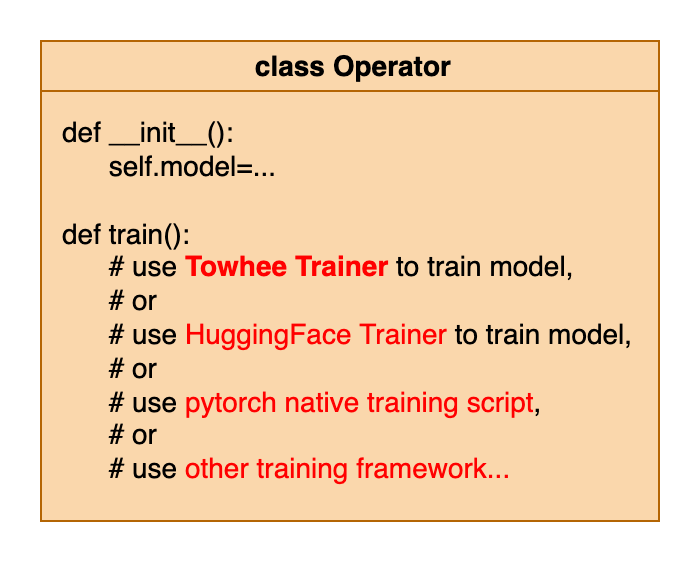


# Towhee Trainer framework
Before training, Towhee Trainer needs to pass in Training config, dataset, and various behavior settings during training. Various indicators can be monitored during the training process. After training, you can save the trained model and use some visualization tools for analysis.

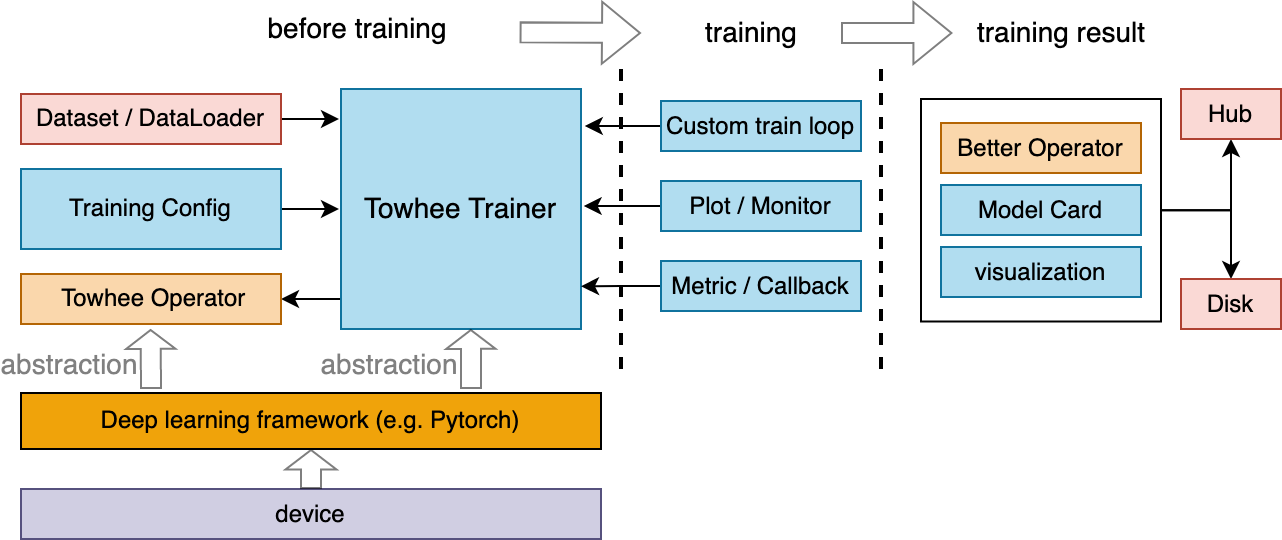

# Training Config

Training config is mainly used to configure various settings in the training process. include:
- Common training hyperparameters such as batch size, epoch, output directory, etc.
- Training device.
- Log mode.
- Some parameters in the learning and optimization process, such as learning rate, optimizer, etc.
- Various callbacks
- Metrics

Generally, only need
```
training_configs = TrainingConfig(
     xxx='some_value_xxx',
     yyy='some_value_yyy'
)
```
and you can instantiate a config and pass it to Trainer().  
You can set up training configs directly in python scripts or with a yaml file.   

For specific parameters, please refer to the [training config guide](https://github.com/towhee-io/examples/blob/main/fine_tune/4_training_configs.ipynb).

# Select training device

In TrainingConfig, there is a parameter `device_str`, which is used to specify the training device. You can have the following options.
- None -> If there is a cuda env in the machine, it will use cuda:0, else cpu.
- "cpu" -> Use cpu only.
- "cuda:2" -> Use the No.2 gpu, the same for other numbers.
- "cuda" -> Use all available gpus, using data parallel. If you want to use several specified gpus to run, you can specify the environment variable `CUDA_VISIBLE_DEVICES` as the number of gpus you need before running your training script.

# Save and Load
For a trainer instance, if you want to resume training, you only need to pass in the `resume_checkpoint_path` parameter in the `train()` interface.
To save the model, use the `save()` method, and to load it, use the `load()` method. Normally, after the end of `train()`, the parameters of the model and training states will be automatically saved to the `output_dir` configured in the training config.

In [3]:
trainer.train(resume_checkpoint_path="./train_dummy_torch/epoch_1")
trainer.save(path="./another_save_path")
trainer.load(path="./another_save_path")
print(trainer.epoch)

2023-02-17 11:08:16,415 - 140662514063168 - trainer.py-trainer:274 - WARNING: TrainingConfig(output_dir='./train_dummy_torch', overwrite_output_dir=True, eval_strategy='epoch', eval_steps=None, batch_size=1, val_batch_size=-1, seed=42, epoch_num=2, dataloader_pin_memory=True, dataloader_drop_last=True, dataloader_num_workers=0, lr=5e-05, metric='Accuracy', print_steps=1, load_best_model_at_end=False, early_stopping={'monitor': 'eval_epoch_metric', 'patience': 4, 'mode': 'max'}, model_checkpoint={'every_n_epoch': 1}, tensorboard={'log_dir': 'mylogdir'}, loss='CrossEntropyLoss', optimizer='Adam', lr_scheduler_type='linear', warmup_ratio=0.0, warmup_steps=0, device_str=None, freeze_bn=False)


epoch=2/2, global_step=1, epoch_loss=5.717026710510254, epoch_metric=0.0
epoch=2/2, global_step=2, epoch_loss=6.157863140106201, epoch_metric=0.0
epoch=2/2, eval_global_step=0, eval_epoch_loss=5.87011194229126, eval_epoch_metric=0.0
2


If you need to freeze some layers of the model before resume training, you can use LayerFreezer to freeze the model layers. You can use the `by_idx()` or `by_names()` method.

In [4]:
from towhee.trainer.utils.layer_freezer import LayerFreezer
from towhee.models import vit
my_model = vit.create_model()
my_freezer = LayerFreezer(my_model)
my_freezer.show_frozen_layers()

[]

In [5]:
my_freezer.by_names(['head'])
my_freezer.show_frozen_layers()

['head']

# Monitor
## Step print or Progressbar
If `print_steps` is not `None`, it means every n step to print loss and metric on the screen, otherwise there will be a corresponding progress bar displayed on the screen in each epoch, instead of printing a line of information.



## Using tensorboard
Tensorboard is a commonly used tool for monitoring indicators in the training process. You must first ensure that the tensorboard is installed in your environment, otherwise this feature can not be used.  
You can specify the `log_dir` of the tensorboard in config, so that you can record your training in the specified directory.

In [6]:
training_config.tensorboard={'log_dir': 'your_log_dir'}

You can just run this command and you can open your browser and go to http://localhost:6006/ to get the tensorboard page.
```
tensorboard --logdir your_log_dir
```

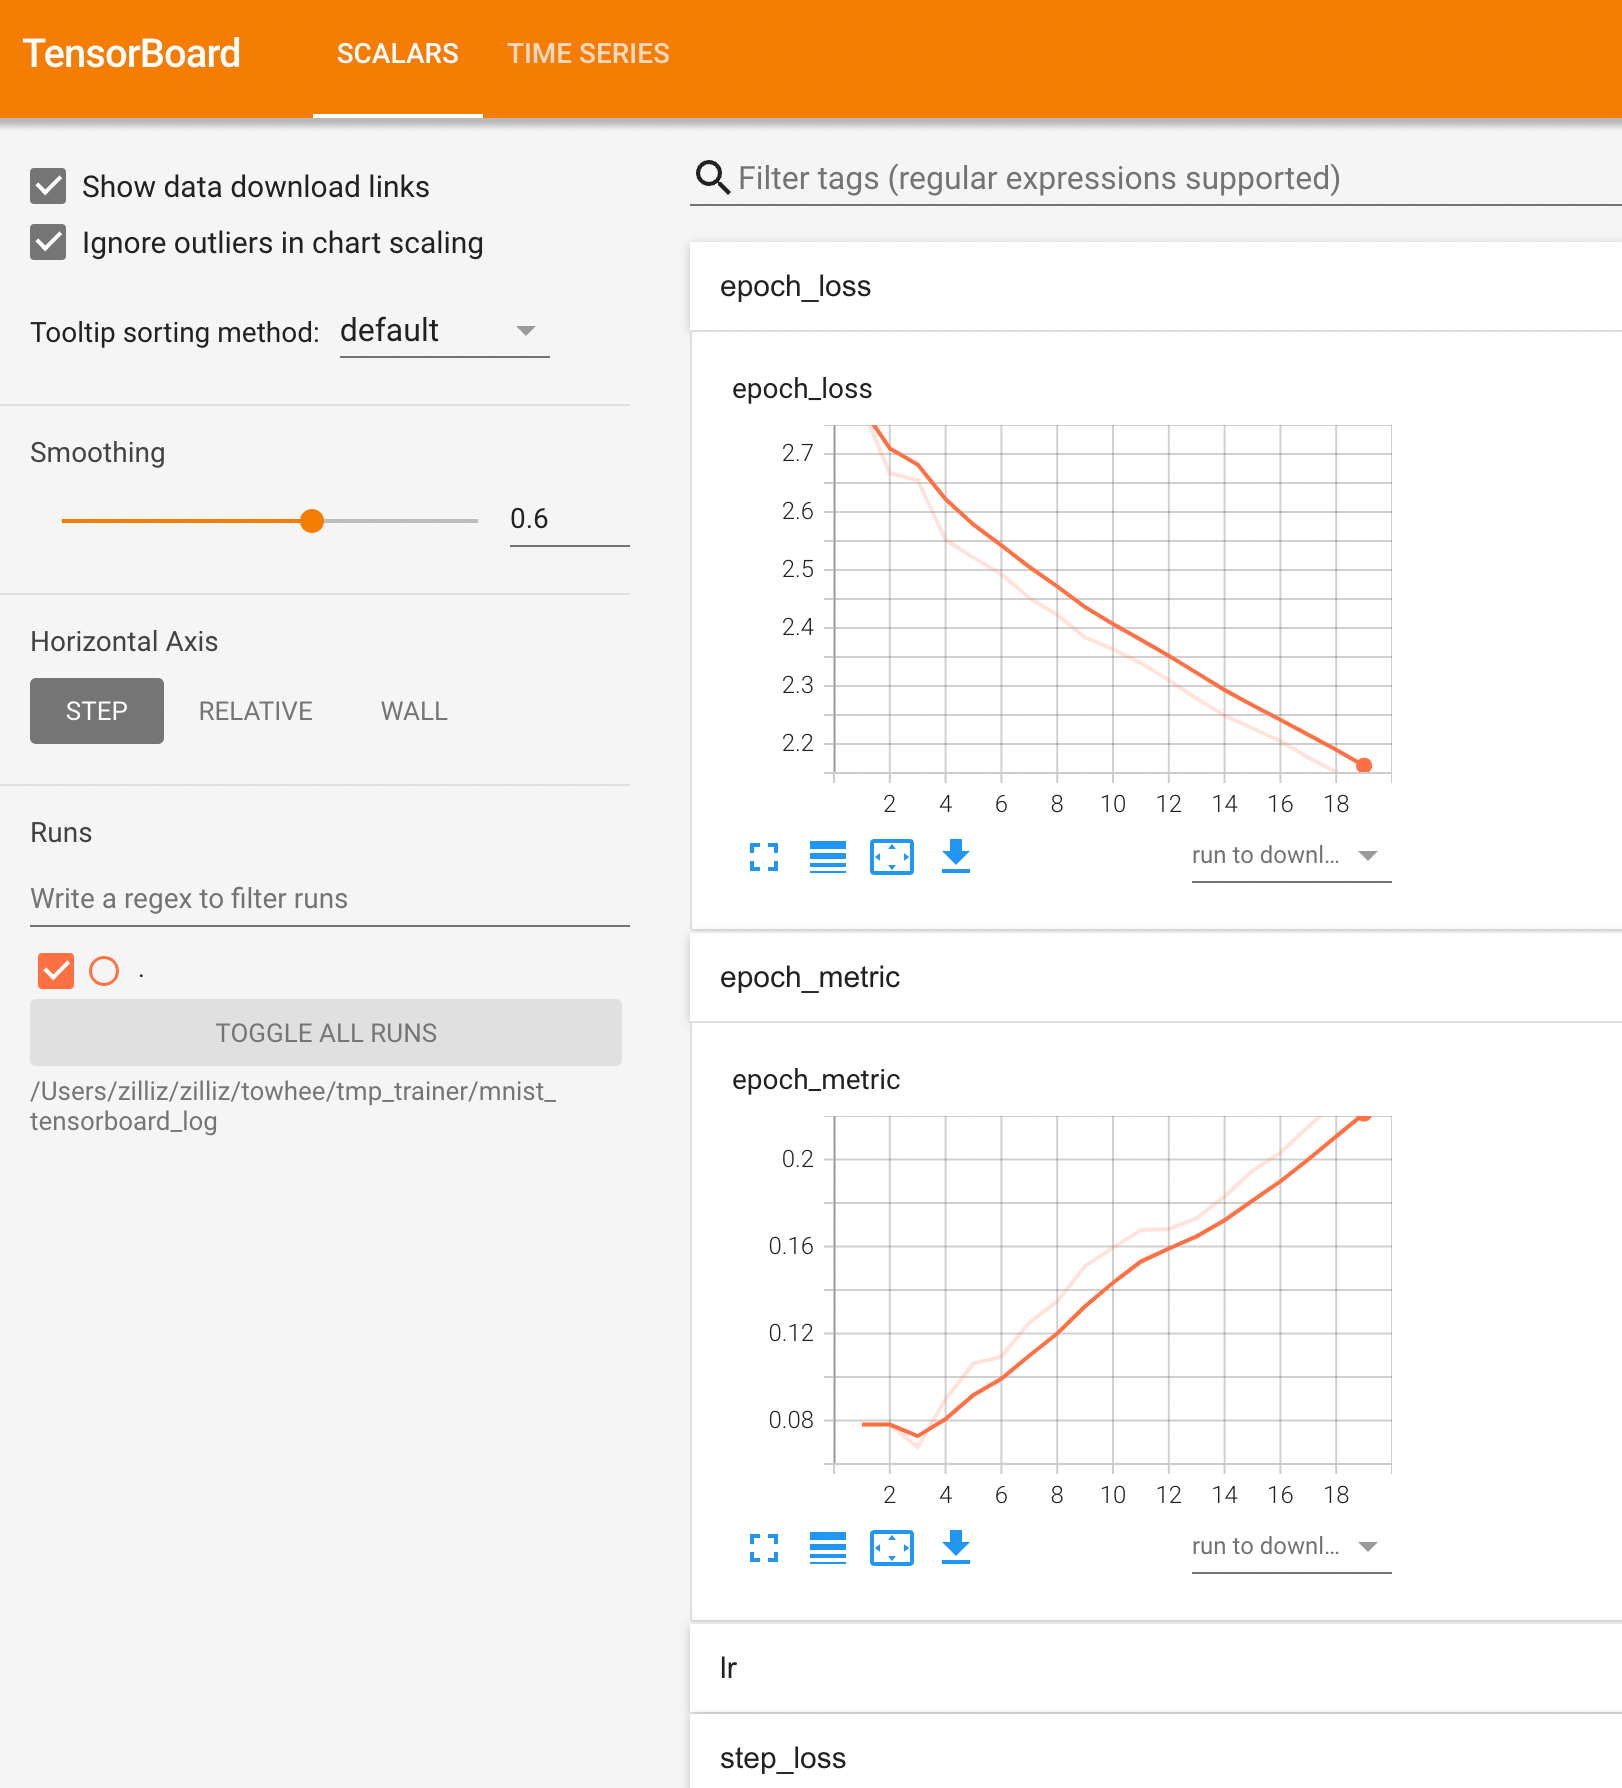

If your want to close the tensorboard monitor, just specify `training_config.tensorboard=None`.

# Using callbacks
You can set custom callbacks during the training process to realize various controls over the training process.
You need to inherit the Callback class, and override and implement a custom corresponding control method. There are many methods that can be overridden: `on_batch_begin()`, `on_batch_end()`, `on_epoch_begin()`, `on_epoch_end()`, `on_train_begin()`, `on_train_end()`, `on_train_batch_begin()`, `on_train_batch_end()`, `on_eval_batch_begin()`, `on_eval_batch_end`, `on_eval_begin`, `on_eval_end`.

In [7]:
from towhee.trainer.callback import Callback

class CustomCallback(Callback):
    def on_batch_begin(self, batch, logs) -> None:
        print('on_batch_begin')
        
trainer.add_callback(CustomCallback())
trainer.train(resume_checkpoint_path="./train_dummy_torch/epoch_1")

2023-02-17 11:08:18,367 - 140662514063168 - trainer.py-trainer:274 - WARNING: TrainingConfig(output_dir='./train_dummy_torch', overwrite_output_dir=True, eval_strategy='epoch', eval_steps=None, batch_size=1, val_batch_size=-1, seed=42, epoch_num=2, dataloader_pin_memory=True, dataloader_drop_last=True, dataloader_num_workers=0, lr=5e-05, metric='Accuracy', print_steps=1, load_best_model_at_end=False, early_stopping={'monitor': 'eval_epoch_metric', 'patience': 4, 'mode': 'max'}, model_checkpoint={'every_n_epoch': 1}, tensorboard={'log_dir': 'mylogdir'}, loss='CrossEntropyLoss', optimizer='Adam', lr_scheduler_type='linear', warmup_ratio=0.0, warmup_steps=0, device_str=None, freeze_bn=False)


on_batch_begin
epoch=2/2, global_step=1, epoch_loss=5.717026710510254, epoch_metric=0.0
on_batch_begin
epoch=2/2, global_step=2, epoch_loss=6.15791130065918, epoch_metric=0.0
on_batch_begin
epoch=2/2, eval_global_step=0, eval_epoch_loss=5.870237827301025, eval_epoch_metric=0.0


There are some built-in callbacks, such as EarlyStoppingCallback, ModelCheckpointCallback. We can set some of their parameters in training config to achieve the corresponding control.

# Set metric
During training, we can also perform evaluation, so we need to use a specific metric. We use [torchmetric](https://torchmetrics.readthedocs.io/en/stable/) 0.7.0 as our metric calculation implementation. You can set the metric you specify in the training config, and the available metric can be obtained through method `TMMetrics.get_tm_avaliable_metrics()`.

In [8]:
training_config.metric = 'Accuracy'

In [9]:
from towhee.trainer.metrics import TMMetrics
TMMetrics.get_tm_avaliable_metrics()

['CatMetric',
 'MaxMetric',
 'MeanMetric',
 'MinMetric',
 'SumMetric',
 'PIT',
 'SDR',
 'SI_SDR',
 'SI_SNR',
 'SNR',
 'PermutationInvariantTraining',
 'ScaleInvariantSignalDistortionRatio',
 'ScaleInvariantSignalNoiseRatio',
 'SignalDistortionRatio',
 'SignalNoiseRatio',
 'AUC',
 'AUROC',
 'F1',
 'ROC',
 'Accuracy',
 'AveragePrecision',
 'BinnedAveragePrecision',
 'BinnedPrecisionRecallCurve',
 'BinnedRecallAtFixedPrecision',
 'CalibrationError',
 'CohenKappa',
 'ConfusionMatrix',
 'F1Score',
 'FBeta',
 'FBetaScore',
 'HammingDistance',
 'Hinge',
 'HingeLoss',
 'IoU',
 'JaccardIndex',
 'KLDivergence',
 'MatthewsCorrcoef',
 'MatthewsCorrCoef',
 'Precision',
 'PrecisionRecallCurve',
 'Recall',
 'Specificity',
 'PSNR',
 'SSIM',
 'MultiScaleStructuralSimilarityIndexMeasure',
 'PeakSignalNoiseRatio',
 'StructuralSimilarityIndexMeasure',
 'CosineSimilarity',
 'ExplainedVariance',
 'MeanAbsoluteError',
 'MeanAbsolutePercentageError',
 'MeanSquaredError',
 'MeanSquaredLogError',
 'PearsonCorrc

# Custom optimizer and loss
In most cases, the corresponding optimizer can be used by specifying the name of the optimizer class in config. But if we implement a custom optimizer, we can use the `set_optimizer()` method to set it. Loss is the same.

In [10]:
from torch import optim

class MyOptimizer(optim.Optimizer):
    def step(self, closure):
        print('my step...')
        
my_optimizer = MyOptimizer(model.parameters(), defaults={})
trainer.set_optimizer(my_optimizer)
type(trainer.optimizer)

__main__.MyOptimizer

In [11]:
class MyTripletLossFunc(torch.nn.Module):
    def forward(self):
        print('forward...')
        return 0

my_loss = MyTripletLossFunc()
trainer.set_loss(my_loss)
type(trainer.loss)

__main__.MyTripletLossFunc

# Custom training step
In some special cases, you may want to customize your own training step, or you have a custom loss calculation process. You can implement them by subclassing the Trainer class and overriding the `train_step()` or `compute_loss()` methods.

When overriding, pay attention to the input and output format of the method to follow the parent class.     

`train_step()` receives `model` and `inputs` as input and returns the `step_logs` dict. The items in `step_logs` dict  are the monitored values printed on the screen, or displayed in the progress bar.

In [12]:
class SubTrainer1(Trainer):
    def train_step(self, model, inputs) -> dict:
        # self.optimizer.zero_grad()
        # y = model(inputs)
        # loss = compute_custom_loss(y)
        # loss.backward()
        # self.optimizer.step()
        # self.lr_scheduler.step()
        step_logs = {"step_loss": ..., "epoch_loss": ..., "epoch_metric": ...}
        return step_logs
    
# train1 = SubTrainer1(...)
# train1.train()

`compute_loss()` receives `model` and `inputs` as input and returns the loss which is pytorch tensor with `grad_fn`.

In [13]:
class SubTrainer2(Trainer):
    def compute_loss(self, model, inputs):
        input1, input2, input3 = inputs
        outputs = model(input1, input2)
        loss = ... # loss_function(outputs, input3)
        return loss

# train2 = SubTrainer2(...)
# train2.train()

This kind of overwriting after inheritance can be used in many methods of Trainer, such as `train_step()`, `compute_loss()`, `evaluate_step()` , `compute_metric()`, `train()` or `evaluate()`. [Here](https://towhee.io/audio-embedding/nnfp/src/branch/main/train_nnfp.py) is an example which overrides the `train_step()` method.

# More examples
For more practical examples, you can refer to [fine-tune examples](https://github.com/towhee-io/examples/tree/main/fine_tune). They include the actual use of the trainer, and the introduction of fine-tuning of some important operators.